### Twitter-roBERTa-base for Sentiment Analysis

In [2]:
from ast import literal_eval
import time
from typing import Union, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
import seaborn as sns

sns.set_style('whitegrid')

In [3]:
!pip install transformers

In [4]:
import torch
import torch.nn.functional as F

In [5]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig


In [6]:
def preprocess_text(text):
    '''Preprocess text: lowercase, remove newlines, strip'''
    return text.lower().replace('\n', ' ').strip()

In [7]:
data = pd.read_csv('reddit_posts_nyc_apt.csv', index_col=0)

In [8]:
data.head()

,subreddit,title,score,num_comments,url,comments
0,r/NYCapartments,Midtown manhattan Studio with great view,1623,289,https://redd.it/1ditjh8,"['$5000 for a studio 😕', 'It comes with person..."
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1432,57,https://redd.it/1at9s69,"['When can I move in?', 'Wow! What a steal!', ..."
2,r/NYCapartments,Those with high rise skyline apartments do you...,1337,249,https://redd.it/1fwnevs,['I didn’t live in one but I worked at an offi...
3,r/NYCapartments,The rent crisis in NYC is becoming increasingl...,1260,371,https://redd.it/1aq7si7,"['Two incomes no kids.', 'Tell me about it, I ..."
4,r/NYCapartments,Happy Monday everyone,942,199,https://redd.it/1auv5ws,['I think average salary context is needed. Ta...


In [9]:
data.dtypes

,0
subreddit,object
title,object
score,int64
num_comments,int64
url,object
comments,object


In [10]:
# needs to be a list and not str
data.comments[0][:10]

"['$5000 fo"

In [11]:
# turn comments to list
data.comments = data.comments.apply(literal_eval)
# Apply preprocessing
data['cleaned_text'] = data['comments'].apply(lambda x: " ".join(preprocess_text(comment) for comment in x if comment))

In [12]:
data.comments[0][:3]

['$5000 for a studio 😕',
 'It comes with personal training from Jimmy Butler?',
 'Man, idgaf if it’s NYC. Yes, it’s beautiful with great amenities but $5k in rent for a studio is outrageous.']

In [13]:
data.cleaned_text[0][:10]

'$5000 for '

In [14]:
def predict_sentiment(text, model, tokenizer, max_length=512):
    '''
    Predicts the sentiment of a text using a pre-trained model and tokenizer.

    Parameters
    ----------
    x: str
        String with input text
    model: transformers.AutoModelForSequenceClassification
        The pre-trained model.
    tokenizer: transformers.AutoTokenizer
        The pre-trained tokenizer.
    max_length: (int, optional)
        The maximum sequence length accepted by the model. Defaults to 512.

    Returns
    -------
    transformers.SequenceClassifierOutput
      The model's output, including predicted labels and probabilities.

    '''

    # Tokenize the text
    encoded_input = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

    # Get the input IDs and check for OOV tokens
    # Check if any of the token IDs in the input are the unknown token ID (OOV).
    input_ids = encoded_input['input_ids']
    oov_indices = [i for i, token_id in enumerate(input_ids[0]) if token_id == tokenizer.unk_token_id]
    if oov_indices:
        print(f"Warning: Found {len(oov_indices)} OOV tokens at positions: {oov_indices} in text: {text}")

    # Get position IDs and check for out-of-range positions
    # where the positions are greater than vocab size
    position_ids = torch.arange(0, input_ids.shape[1], dtype=torch.long,
                                device=input_ids.device)
    out_of_range_positions = [i for i, pos_id in enumerate(position_ids) if pos_id >= tokenizer.vocab_size]
    if out_of_range_positions:
        print(f"Warning: Found {len(out_of_range_positions)} position IDs out of range: {out_of_range_positions} in text: {text}")

    # Perform inference
    # Disable gradient calculation during inference
    with torch.no_grad():
        output = model(**encoded_input)

    return output

In [15]:
def interpret_sentiment(output):
    """Interprets the sentiment from the model's output.

    Parameters
    ----------
        output: transformers.SequenceClassifierOutput:
        The model's output.

    Returns
    -------
        dict: A dictionary containing the predicted sentiment label and its probability.
               e.g., {'label': 'positive', 'prob': 0.95}
    """
    # Calculate the probabilities of each sentiment using softmax
    probs = F.softmax(output.logits, dim=1)

    # Get the predicted label (index of the highest probability)
    predicted_label_index = torch.argmax(probs).item()

    # Map the label index to a sentiment label
    sentiment_mapping = {
        0: "negative",
        1: "neutral",
        2: "positive"
    }
    predicted_label = sentiment_mapping.get(predicted_label_index, "unknown")

    # Get the probability of the predicted label
    predicted_prob = probs[0][predicted_label_index].item()

    # Return the label and probability as a dictionary
    return {'label': predicted_label, 'prob': predicted_prob}

In [16]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
# Predict sentiment based on cleaned_text column
# this return sentiment output with logit values
data['sentiment_output'] = data['cleaned_text'].apply(lambda text: predict_sentiment(text, model, tokenizer))

In [18]:
# Interpret sentiment output
# get sentiment prediction and probability
data['sentiment_dict'] = data['sentiment_output'].apply(interpret_sentiment)

In [19]:
data.head()

,subreddit,title,score,num_comments,url,comments,cleaned_text,sentiment_output,sentiment_dict
0,r/NYCapartments,Midtown manhattan Studio with great view,1623,289,https://redd.it/1ditjh8,"[$5000 for a studio 😕, It comes with personal ...",$5000 for a studio 😕 it comes with personal tr...,"{'logits': [[tensor(-0.7412), tensor(0.1882), ...","{'label': 'positive', 'prob': 0.5385751128196716}"
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1432,57,https://redd.it/1at9s69,"[When can I move in?, Wow! What a steal!, Pets...",when can i move in? wow! what a steal! pets? 3...,"{'logits': [[tensor(0.6609), tensor(0.3187), t...","{'label': 'negative', 'prob': 0.529732346534729}"
2,r/NYCapartments,Those with high rise skyline apartments do you...,1337,249,https://redd.it/1fwnevs,[I didn’t live in one but I worked at an offic...,i didn’t live in one but i worked at an office...,"{'logits': [[tensor(-1.7323), tensor(0.3786), ...","{'label': 'positive', 'prob': 0.7256765961647034}"
3,r/NYCapartments,The rent crisis in NYC is becoming increasingl...,1260,371,https://redd.it/1aq7si7,"[Two incomes no kids., Tell me about it, I lit...","two incomes no kids. tell me about it, i liter...","{'logits': [[tensor(1.8360), tensor(0.0500), t...","{'label': 'negative', 'prob': 0.8410271406173706}"
4,r/NYCapartments,Happy Monday everyone,942,199,https://redd.it/1auv5ws,[I think average salary context is needed. Tak...,i think average salary context is needed. take...,"{'logits': [[tensor(0.4163), tensor(0.3762), t...","{'label': 'negative', 'prob': 0.44663679599761..."


In [76]:
# How many comments do we have on posts?
data.comments.map(lambda x: len(x)).sum()

6187

In [20]:
# extract sentiment and probabilities into 2 separate columns
data['sentiment'] = data.sentiment_dict.map(lambda x: x['label'])
data['sentiment_prob'] = data.sentiment_dict.map(lambda x: x['prob'])

In [21]:
data.head()

,subreddit,title,score,num_comments,url,comments,cleaned_text,sentiment_output,sentiment_dict,sentiment,sentiment_prob
0,r/NYCapartments,Midtown manhattan Studio with great view,1623,289,https://redd.it/1ditjh8,"[$5000 for a studio 😕, It comes with personal ...",$5000 for a studio 😕 it comes with personal tr...,"{'logits': [[tensor(-0.7412), tensor(0.1882), ...","{'label': 'positive', 'prob': 0.5385751128196716}",positive,0.538575
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1432,57,https://redd.it/1at9s69,"[When can I move in?, Wow! What a steal!, Pets...",when can i move in? wow! what a steal! pets? 3...,"{'logits': [[tensor(0.6609), tensor(0.3187), t...","{'label': 'negative', 'prob': 0.529732346534729}",negative,0.529732
2,r/NYCapartments,Those with high rise skyline apartments do you...,1337,249,https://redd.it/1fwnevs,[I didn’t live in one but I worked at an offic...,i didn’t live in one but i worked at an office...,"{'logits': [[tensor(-1.7323), tensor(0.3786), ...","{'label': 'positive', 'prob': 0.7256765961647034}",positive,0.725677
3,r/NYCapartments,The rent crisis in NYC is becoming increasingl...,1260,371,https://redd.it/1aq7si7,"[Two incomes no kids., Tell me about it, I lit...","two incomes no kids. tell me about it, i liter...","{'logits': [[tensor(1.8360), tensor(0.0500), t...","{'label': 'negative', 'prob': 0.8410271406173706}",negative,0.841027
4,r/NYCapartments,Happy Monday everyone,942,199,https://redd.it/1auv5ws,[I think average salary context is needed. Tak...,i think average salary context is needed. take...,"{'logits': [[tensor(0.4163), tensor(0.3762), t...","{'label': 'negative', 'prob': 0.44663679599761...",negative,0.446637


# Notes

Softmax converts the models raw scores (logits) into a
probability distribution that represents the models
confidence in each possible class. This allows for easier interpretation and
decision-making based on the predicted probabilities.

Example:
The original logits [-1, 0, 2] represent the model's raw scores for each sentiment class.
After applying softmax, we get the probabilities [0.045, 0.119, 0.835].
These probabilities can be interpreted as follows:
* There's a 4.5% probability the text is negative.
* There's an 11.9% probability the text is neutral.
* There's an 83.5% probability the text is positive.


In [69]:
data.sentiment.value_counts().reset_index()

,sentiment,count
0,negative,46
1,positive,35
2,neutral,19


In [31]:
data.sentiment_prob.describe()

,sentiment_prob
count,100.000000
mean,0.645380
std,0.162003
min,0.391733
25%,0.505781
50%,0.620151
75%,0.755594
max,0.987342


## Data Visualization

* Sentiment distribution - a big majority of comments are negative
* Sentiment probability distributions: positive and negative are wider ranging and neutral is smallest



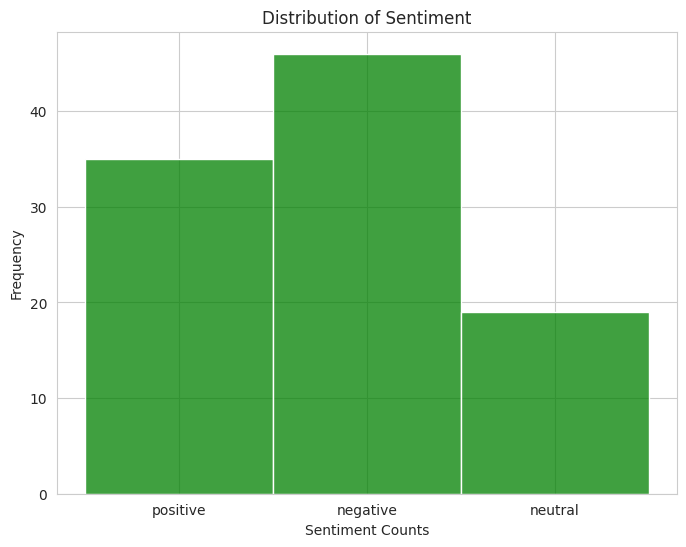

In [43]:
# plot sentiment distribution
# we can see there are more negativ sentiments
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data.sentiment, ax=ax, kde=False, color='green')
_ = ax.set_title('Distribution of Sentiment')
_ = ax.set_xlabel('Sentiment Counts')
_ = ax.set_ylabel('Frequency')

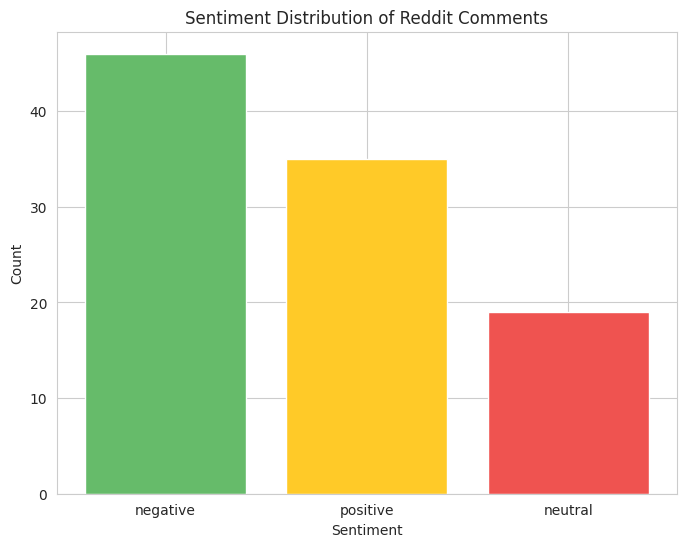

In [75]:
# sentiment values
sentiment_df = data.sentiment.value_counts().reset_index()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_df['sentiment'], sentiment_df['count'], color=['#66BB6A', '#FFCA28', '#EF5350'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Reddit Comments')
plt.show()


Text(0, 0.5, 'Frequency')

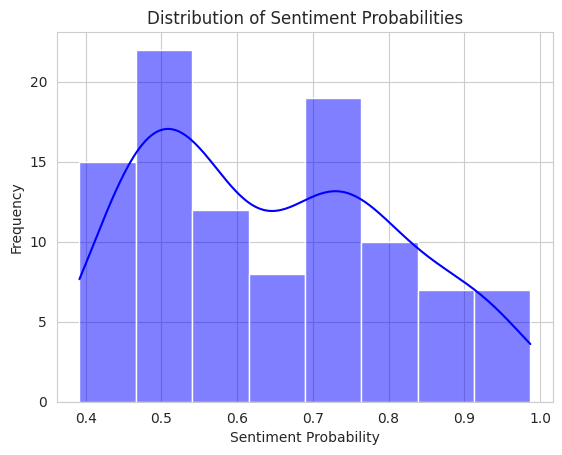

In [45]:
fig, ax = plt.subplots()
sns.histplot(data.sentiment_prob, ax=ax, kde=True, color='Blue')
ax.set_title('Distribution of Sentiment Probabilities')
ax.set_xlabel('Sentiment Probability')
ax.set_ylabel('Frequency')

In [59]:
sentiment_counts = data.sentiment.value_counts().reset_index()
sentiment_counts

,sentiment,count
0,negative,46
1,positive,35
2,neutral,19


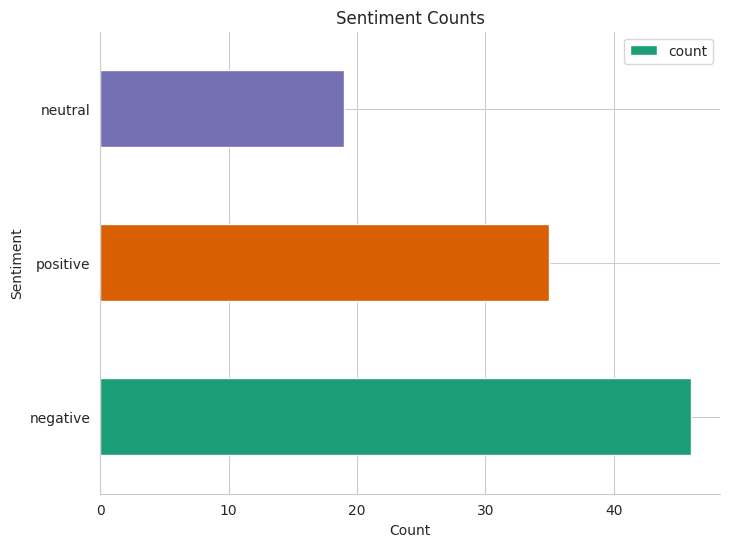

In [70]:
# plot sentiment counts
fig, ax = plt.subplots(figsize=(8, 6))
g = sentiment_counts.plot(kind='barh', x = 'sentiment', y ='count',
                      color=sns.palettes.mpl_palette('Dark2'), ax=ax)
_ = plt.xlabel('Count')
_ =  plt.ylabel('Sentiment')
_ =  plt.title('Sentiment Counts')
_ =  plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-89-dca522670869>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.violinplot(data, x='sentiment_prob', y='sentiment', palette='Set1', ax = ax)


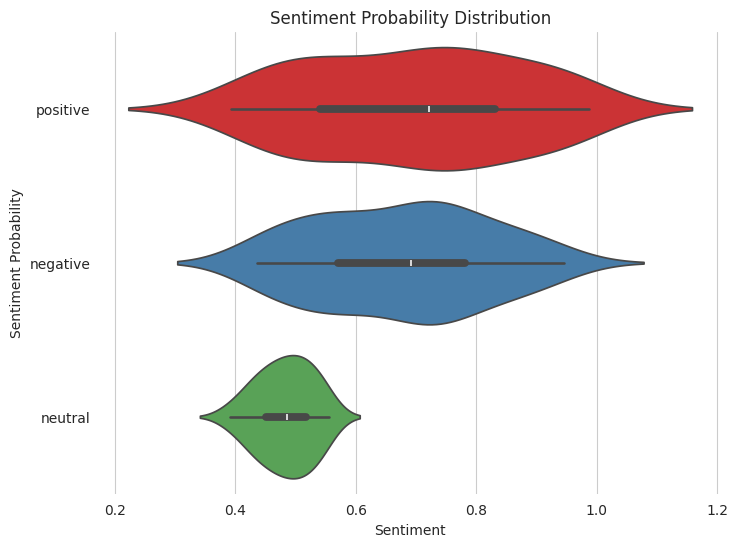

In [89]:
# sentiment vs sentiment_prob
fig, ax = plt.subplots(figsize=(8, 6))
g = sns.violinplot(data, x='sentiment_prob', y='sentiment', palette='Set1', ax = ax)
_ = sns.despine(top=True, right=True, bottom=True, left=True)

_ = plt.title('Sentiment Probability Distribution')
_ = plt.xlabel('Sentiment')
_ = plt.ylabel('Sentiment Probability')

In [48]:
data.head()

,subreddit,title,score,num_comments,url,comments,cleaned_text,sentiment_output,sentiment_dict,sentiment,sentiment_prob
0,r/NYCapartments,Midtown manhattan Studio with great view,1623,289,https://redd.it/1ditjh8,"[$5000 for a studio 😕, It comes with personal ...",$5000 for a studio 😕 it comes with personal tr...,"{'logits': [[tensor(-0.7412), tensor(0.1882), ...","{'label': 'positive', 'prob': 0.5385751128196716}",positive,0.538575
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1432,57,https://redd.it/1at9s69,"[When can I move in?, Wow! What a steal!, Pets...",when can i move in? wow! what a steal! pets? 3...,"{'logits': [[tensor(0.6609), tensor(0.3187), t...","{'label': 'negative', 'prob': 0.529732346534729}",negative,0.529732
2,r/NYCapartments,Those with high rise skyline apartments do you...,1337,249,https://redd.it/1fwnevs,[I didn’t live in one but I worked at an offic...,i didn’t live in one but i worked at an office...,"{'logits': [[tensor(-1.7323), tensor(0.3786), ...","{'label': 'positive', 'prob': 0.7256765961647034}",positive,0.725677
3,r/NYCapartments,The rent crisis in NYC is becoming increasingl...,1260,371,https://redd.it/1aq7si7,"[Two incomes no kids., Tell me about it, I lit...","two incomes no kids. tell me about it, i liter...","{'logits': [[tensor(1.8360), tensor(0.0500), t...","{'label': 'negative', 'prob': 0.8410271406173706}",negative,0.841027
4,r/NYCapartments,Happy Monday everyone,942,199,https://redd.it/1auv5ws,[I think average salary context is needed. Tak...,i think average salary context is needed. take...,"{'logits': [[tensor(0.4163), tensor(0.3762), t...","{'label': 'negative', 'prob': 0.44663679599761...",negative,0.446637


<ipython-input-79-e8c3bcd76f48>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='sentiment_prob', y='sentiment', inner='stick', palette='Dark2')


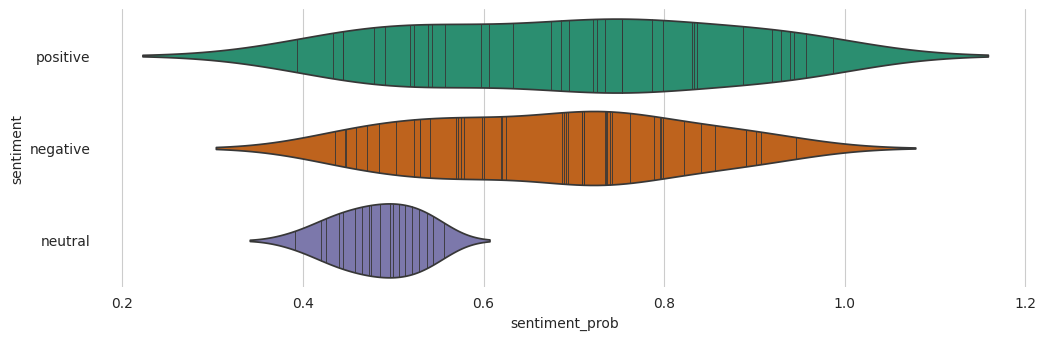

In [79]:
# @title sentiment vs sentiment_prob

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='sentiment_prob', y='sentiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Examine a few sample comments to understand what is happening

The below section goes into each step of the functions above for a few comments and examines each component.

In [ ]:
# look at a few rows w high probabilities and pos/neg sentiments to compare results

In [49]:
i = 2

In [50]:
data.cleaned_text[i]

'i didn’t live in one but i worked at an office in hudson yards on the 72nd floor and the view never got old. i got used to it. i never got tired of it. i got used to mine, but continued to vicariously live through other people when they saw it the first time. impressed my girlfriend at the time enough to become my wife so all in all worth it.   but after 6.5 years of a 6 floor walk up i’m happy to be a ground floor dweller now. it never gets old for me. besides the view, i’ve noticed my apartment is very quiet. there are no bugs or rodents that make it up this high, either. totally worth it for me. https://preview.redd.it/ktgoakyjrxsd1.jpeg?width=4032&format=pjpg&auto=webp&s=4aa5fc69e68eb6f4e2a39e681be1df032a4acdfc  never gets old. as for most things in life you eventually do get used to it but it is still nice it\'s hard to watch squirrels playing in a tree from there. my friends in hoboken had a view of the manhattan skyline for like 2-3 years. they became used to it after some time

In [50]:
# let's take a few sample comments and see how the model does
sample_comment = "I didn’t live in one but I worked at an office in Hudson Yards on the 72nd floor and the view never got old."
sample_comment+= "I got used to it. I never got tired of it."
sample_comment+= "But after 6.5 years of a 6 floor walk up I’m happy to be a ground floor dweller now."
sample_comment+= "It never gets old for me. Besides the view, I’ve noticed my apartment is very quiet. There are no bugs or rodents that make it up this high, either. Totally worth it for me."

In [47]:
len(sample_comment)

407

In [27]:
# set max_length to 512
max_length = 512

In [51]:
# Tokenize the sample_comment, ensuring truncation and padding to the maximum length
encoded_comment = tokenizer(
    sample_comment,
    return_tensors='pt',
    truncation=True,
    # Add padding to max_length
    padding='max_length',
    max_length=max_length
)

In [52]:
encoded_comment

{'input_ids': tensor([[    0,   100,   399,    17,    27,    90,   697,    11,    65,    53,
            38,  1006,    23,    41,   558,    11,  8187, 35161,    15,     5,
          4801,  1187,  1929,     8,     5,  1217,   393,   300,   793,     4,
           100,   300,   341,     7,    24,     4,    38,   393,   300,  7428,
             9,    24,     4,  1708,    71,   231,     4,   245,   107,     9,
            10,   231,  1929,  1656,    62,    38,    17,    27,   119,  1372,
             7,    28,    10,  1255,  1929, 23238,   254,   122,     4,   243,
           393,  1516,   793,    13,   162,     4,  8705,     5,  1217,     6,
            38,    17,    27,   548,  5324,   127,  3537,    16,   182,  5128,
             4,   345,    32,   117, 19230,    50, 37304,    14,   146,    24,
            62,    42,   239,     6,  1169,     4, 41380,   966,    24,    13,
           162,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [54]:
encoded_comment['input_ids']

tensor([[    0,   100,   399,    17,    27,    90,   697,    11,    65,    53,
            38,  1006,    23,    41,   558,    11,  8187, 35161,    15,     5,
          4801,  1187,  1929,     8,     5,  1217,   393,   300,   793,     4,
           100,   300,   341,     7,    24,     4,    38,   393,   300,  7428,
             9,    24,     4,  1708,    71,   231,     4,   245,   107,     9,
            10,   231,  1929,  1656,    62,    38,    17,    27,   119,  1372,
             7,    28,    10,  1255,  1929, 23238,   254,   122,     4,   243,
           393,  1516,   793,    13,   162,     4,  8705,     5,  1217,     6,
            38,    17,    27,   548,  5324,   127,  3537,    16,   182,  5128,
             4,   345,    32,   117, 19230,    50, 37304,    14,   146,    24,
            62,    42,   239,     6,  1169,     4, 41380,   966,    24,    13,
           162,     4,     2]])

In [55]:
type(encoded_comment)

transformers.tokenization_utils_base.BatchEncoding

In [56]:
encoded_comment.keys()

dict_keys(['input_ids', 'attention_mask'])

In [57]:
# these are the input ids: the numerical ids representing the tokens in the input
# grab the first 5 ids
encoded_comment['input_ids'][0][0:5]

tensor([  0, 100, 399,  17,  27])

In [58]:
# these are the input ids
encoded_comment['attention_mask'][0][0:5]

tensor([1, 1, 1, 1, 1])

In [61]:
# get the original text back from IDs
tokenizer.decode(encoded_comment['input_ids'][0][0:30])

'<s>I didn’t live in one but I worked at an office in Hudson Yards on the 72nd floor and the view never got old.'

In [77]:
output = model(**encoded_comment)
print(output)

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2045, -0.0916,  2.7450]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


#### Notes

Logits refer to the raw, unnormalized scores outputted by the model's final layer before the softmax function is applied.
These scores represent the model's prediction for each sentiment class (negative, neutral, positive).


**Model Output:** The `predict_sentiment` function returns the `output` from the `model`, which contains the `logits`.

**`output.logits`:**  These are the raw scores for each class. For instance, `output.logits` might be `[-1.5, 0.2, 2.8]` which means the model is more inclined to predict the third sentiment class (positive), but it still hasn't been converted to a probability yet.

**Softmax Function:** The `interpret_sentiment` function then uses the `F.softmax(output.logits, dim=1)` function to convert the logits into probabilities. The softmax function scales these raw scores, making them sum to 1, allowing you to interpret them as probabilities.

**Example:**
If the logits are `[-1.5, 0.2, 2.8]`, after softmax, you'll get a probability distribution like `[0.045, 0.119, 0.835]`, which indicates the probability of the input being negative, neutral, and positive, respectively.

**In essence, logits are the raw predictions of the model before the probability conversion, while the softmax-transformed values are the interpretable probabilities of each sentiment class.**


In [120]:
# all input Ids
input_ids = encoded_comment['input_ids']

In [121]:
input_ids.shape

torch.Size([1, 512])

In [123]:
# vocabulary size
vocab_size = tokenizer.vocab_size

In [124]:
# Check if any position IDs are out of range
position_ids = torch.arange(0, input_ids.shape[1], dtype=torch.long, device=input_ids.device)
out_of_range_positions = [i for i, pos_id in enumerate(position_ids) if pos_id >= vocab_size]
if out_of_range_positions:
    print(f"Warning: Found {len(out_of_range_positions)} position IDs out of range: {out_of_range_positions}")


In [129]:
output.keys()

odict_keys(['logits'])

In [130]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.9768,  0.1379,  2.0923]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [131]:
# negative, neutral, positive logits
# positive is highest based on logits
output.logits

tensor([[-1.9768,  0.1379,  2.0923]], grad_fn=<AddmmBackward0>)

In [66]:
# get config for mapping
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
config = AutoConfig.from_pretrained(MODEL)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

In [67]:
config.id2label

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [65]:
# Get probabilities using softmax
# we can see it is postive
probs = F.softmax(output.logits, dim=1)
print(probs)

tensor([[0.0148, 0.1222, 0.8630]], grad_fn=<SoftmaxBackward0>)


In [138]:
# Get the predicted label (index of the highest probability)
predicted_label_index = torch.argmax(probs).item()

In [139]:
predicted_label_index

2

In [140]:
print(f"Predicted sentiment fis: {config.id2label[predicted_label_index]}")

predicted sentiment is positive
